<a href="https://colab.research.google.com/github/Zhr-Srj/TripSimAcin-AMR/blob/main/Code/TripSimAcin_AMR_validation3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we want to compare TripSimAcin-AMR with traditional machine learning models 10 times and report the results in the form of average over the results for this 10 times.

This file includes results mentioned in Table 6.

# Required packages

In [ ]:
pip install xgboost

In [ ]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from random import sample, shuffle

from sklearn.utils import shuffle as sk_shuffle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.callbacks import  History

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost

# Data preparation

## Loading train-test dataset

In [ ]:
with open(r'/content/drive/MyDrive/Dataset_SHAP_u.txt') as f:
    data = []
    for line in f.readlines():
        row = []
        for elem in line.split(sep=','):
            row.append(int(elem.strip()))
        data.append(row)
print(len(data))
print(len(data[0]))

7207
2996


In [ ]:
#Reading phenotypes file
with open(r'/content/drive/MyDrive/DrugLabel_SHAP_u.txt') as fy:
    labels = []
    drugs = [] #stores drug name in each row
    row = 0 # row number of each label (is needed because data is reordered while spliting)
    reader = csv.reader(fy)
    for i in reader:
        labels.append([row, int(i[1])])
        drugs.append(i[0])
        row += 1

print(len(labels))
print(len(drugs))
print(labels[:5])

7207
7207
[[0, 1], [1, 0], [2, 0], [3, 1], [4, 1]]


In [ ]:
labels = np.asarray(labels)

### A survey on data

In [ ]:
unq_drugs = set(drugs)
len(unq_drugs)

12

In [ ]:
per_drug_dic = {}
for i, drug in enumerate(drugs_unique):
  if drug not in per_drug_dic.keys():
    per_drug_dic[drug] = [0, 0]  # num of resistant, num of susceptible
  if labels[i][1] == 0:
    per_drug_dic[drug][1] += 1
  else:
    per_drug_dic[drug][0] += 1

per_drug_dic

In [ ]:
keys = []
for element in data:
  if np.asarray(element[:2693]).tobytes() not in keys:
    keys.append(np.asarray(element[:2693]).tobytes())

print("Number of strains in dataset", len(keys))

Number of strains in dataset 766


## Train-Test split

In [ ]:
def balanced_train_test_split(data, labels, drugs, n):
  """
  Performs a train_test_split, setting n susceptibles and n resistant strains aside for each drug
  returns x_train, x_test, y_train, y_test
  """

  data, labels = sk_shuffle(data, labels)

  x_train = []
  x_test = []
  y_train = []
  y_test = []

  idx = {} # A dic containig indices of susceptible and resistant strain
            # for each drug

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  len_xtrain = 0
  len_xtest = 0

  for drug in unq_drugs:

    s_set = idx[(drug, 'S')]
    for i in range(len(s_set)-n):
      x_train.append(data[s_set[i]])
      y_train.append(labels[s_set[i]])
    for i in range(1, n+1):
      x_test.append(data[s_set[-i]])
      y_test.append(labels[s_set[-i]])

    r_set = idx[(drug, 'R')]
    for i in range(len(r_set)-n):
      x_train.append(data[r_set[i]])
      y_train.append(labels[r_set[i]])
    for i in range(1, n+1):
      x_test.append(data[r_set[-i]])
      y_test.append(labels[r_set[-i]])

    # For confirming it's working properly
    print("for drug ", drug, "# of train samples: ", len(x_train)-len_xtrain, )
    len_xtrain = len(x_train)
    print("for drug ", drug, "# of test samples: ", len(x_test)-len_xtest)
    len_xtest = len(x_test)

  return x_train, x_test, y_train, y_test

In [ ]:
def make_balanced_triplets(samples, labels, drugs, num):
  """For each drug in drugs samples...
  makes:
  - n triplets which are both Susceptible to drug (S, S)
  - n triplets which are (R, R)
  - n triplets which are (S, R)
  - n triplets which are (R, S)
  """
  bac_shape = 2693

  idx = {} # A dic containig indices of susceptible and resistant strain
            # for each drug

  triplet = [] # Made from samples which are not part of external_test_sets
  triLabels = [] # Labels corresponding to triplets

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  for drug in unq_drugs:

    s_len = len(idx[(drug, 'S')])
    r_len = len(idx[(drug, 'R')])
    n = min(num, int(s_len*(s_len-1)/2), int(r_len*(r_len-1)/2))

    ss = [(i, j) for i in idx[(drug, 'S')] for j in idx[(drug, 'S')] if j>i]
    ss_sampled = sample(ss, n)

    rr = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'R')] if j>i]
    rr_sampled = sample(rr, n)

    rs = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'S')]]
    neg_samples = sample(rs, 2*n)
    rs_sampled = neg_samples[:n]
    sr_sampled = [(t[1], t[0]) for t in neg_samples[n:]]

    for k in range(n):
      # Making (S, S, d) triplets
      triplet.append( samples[ss_sampled[k][0]][:bac_shape] + samples[ss_sampled[k][1]][:bac_shape] +
                        samples[ss_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 0]) # 1: both phenos the same. First: 0, sencond? --> 0

      # Making (R, R, d) triplets
      triplet.append( samples[rr_sampled[k][0]][:bac_shape] + samples[rr_sampled[k][1]][:bac_shape] +
                        samples[rr_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 1]) # 1: both phenos the same. First: 1, sencond? --> 1

      # Making (R, S, d) triplets
      triplet.append( samples[rs_sampled[k][0]][:bac_shape] + samples[rs_sampled[k][1]][:bac_shape] +
                         samples[rs_sampled[k][0]][bac_shape:])
      triLabels.append([0, 1]) # 0: phenos different. First: 1, sencond? --> 0

      # Making (S, R, d) triplets
      triplet.append( samples[sr_sampled[k][0]][:bac_shape] + samples[sr_sampled[k][1]][:bac_shape] +
                         samples[sr_sampled[k][0]][bac_shape:])
      triLabels.append([0, 0]) # 0: phenos different. First: 0, sencond? --> 1

  return np.array(triplet), np.array(triLabels)

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for 

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

18404
5689
18404
[1 0]


In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

# TSA-Net architecture

In [ ]:
def create_siamese_model(input_shape1, input_shape2, input_shape3):

    right_input = Input(shape=input_shape2)
    left_input = Input(shape=input_shape1)
    third_input = Input(shape=input_shape3)

    shared_layer1 = Dense(1024, activation='leaky_relu')
    shared_layer2 = Dense(512, activation='leaky_relu')
    shared_layer3 = Dense(256, activation='leaky_relu')
    shared_bn = BatchNormalization() # shared batch normalization layer
    drug_bn = BatchNormalization() # drug batch normalization layer

    encoded_l = shared_layer1(left_input)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer2(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer3(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_bn(encoded_l)

    encoded_r = shared_layer1(right_input)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer2(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer3(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_bn(encoded_r)

    encoded_c = Dense(256, activation='leaky_relu')(third_input)
    encoded_c = Dropout(0.2)(encoded_c)
    encoded_c = drug_bn(encoded_c)

    concatenated = Concatenate()([encoded_l, encoded_r, encoded_c])

    dense1 = Dense(128, activation='leaky_relu')(concatenated)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='leaky_relu')(dense1)
    dense2 = Dropout(0.2)(dense2)
    prediction = Dense(1, activation='sigmoid')(dense2)

    siamese_net = Model(inputs=[left_input, right_input, third_input], outputs=prediction)

    optimizer = Adam(learning_rate=0.001)
    siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", AUC(name='auc-roc')])

    return siamese_net

# Evaluations

## Functions

In [ ]:
def evaluation(true_labels, pred_labels):

  Dis_pred = []
  for i in pred_labels:
    if i < 0.5:
      Dis_pred.append(0)
    else:
      Dis_pred.append(1)

  acc = accuracy_score(true_labels, Dis_pred)
  auc = roc_auc_score(true_labels, Dis_pred)
  print('Accuracy: ', acc)
  print('ROC-AUC: ', auc)

  TN, FP, FN, TP = confusion_matrix(true_labels, Dis_pred, labels=[0, 1]).ravel()
  sen = TP/(TP+FN)
  spc = TN/(TN+FP)
  print("Sensitivity: ", sen)
  print('Specificity: ', spc)

  conf_matrix = confusion_matrix(true_labels, Dis_pred, labels=[0, 1])
  plt.figure(figsize=(4, 4))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['True Negative', 'True Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  return acc, auc, sen, spc

In [ ]:
def ExternalTest(x0_test,x1_test,x0_train,x1_train):
  """
  Takes as input paired data and
  makes each test sample pair with train samples of the same drug (triplet --> b1, b2, d).
  x0_test: test samples with phenotype 0
  x1_test: test samples with phenotype 1
  x0_train: train samples with phenotype 0
  x1_train: train samples with phenotype 1
  """
  dataset_test1=[] # concat train
  label_test1=[]
  Indexsample=[]

  for i in range(len(x0_test)):
    for j in range(len(x0_train)):
      if (x0_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",0,0")   #index in test, x0_test pheno, x0_train pheno

  for i in range(len(x0_test)):
    for j in range(len(x1_train)):
      if (x0_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",0,1")   #index in test, x0_test pheno, x1_train pheno

  for i in range(len(x1_test)):
    for j in range(len(x0_train)):
      if (x1_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",1,0")  #index in test,x1_test,x0_train

  for i in range(len(x1_test)):
    for j in range(len(x1_train)):
      if (x1_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",1,1")  #index in test,x1_test,x1_train

  return (np.asarray(dataset_test1), np.asarray(label_test1), Indexsample)

In [ ]:
def DefineTest2(x0_test, x1_test, Indexsample, y_pred):

  """
  Aggregates labels predicted by TSA_Net to get a unified prediction of resistence
  phenotype (Desired output for TripSimAcin_AMR)
  """
  Pred=[]
  Label=[]

  # START of x0_test
  for i in range(len(x0_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0

    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==0: #type test

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(0)

  # END of x0_test
  ######################################################
  # START of x1_test
  for i in range(len(x1_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0
    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==1: #type test

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(1)

  return(Pred,Label)

In [ ]:
def RS_splitter(data, labels):
  """
  Takes as input a dataset and corresponding labels (in terms of list of 0s and 1s)
  returns data0, data1
  which are set of susceptible and resistant strains in data, respectively
  """
  data0 = [] # list of susceptible strains' features
  data1 = [] # list of resistant strains' features

  for i, l in enumerate(labels):
    if l == 0:
      data0.append(data[i])
    else:
      data1.append(data[i])

  return data0, data1

In [ ]:
rf_acc = []
rf_auc = []
rf_sen = []
rf_spc = []

svm_acc = []
svm_auc = []
svm_sen = []
svm_spc = []

xgb_acc = []
xgb_auc = []
xgb_sen = []
xgb_spc = []

nn_acc = []
nn_auc = []
nn_sen = []
nn_spc = []

# Round 1

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Last epoch \\
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9799 - auc-roc: 0.9973 - loss: 0.0576

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


Accuracy:  0.9928276461638774
ROC-AUC:  0.9928276461638774
Sensitivity:  0.9907628776352967
Specificity:  0.9948924146924581


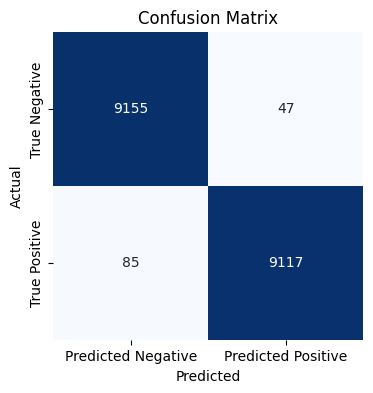

(0.9928276461638774,
 0.9928276461638774,
 0.9907628776352967,
 0.9948924146924581)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.8916666666666667
ROC-AUC:  0.8916666666666666
Sensitivity:  0.9333333333333333
Specificity:  0.85


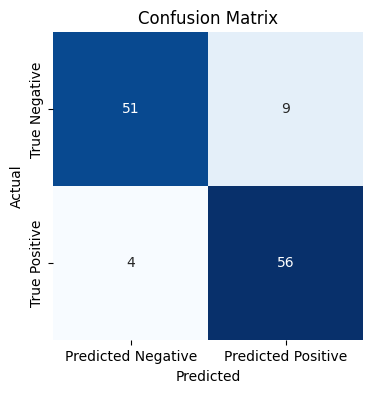

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666666
Sensitivity:  0.95
Specificity:  0.8833333333333333


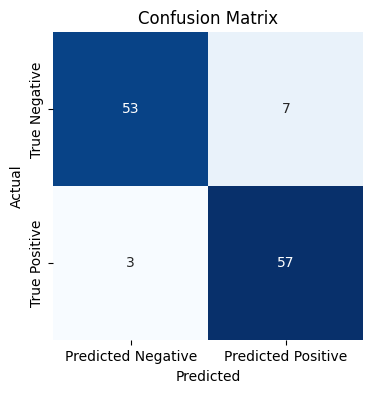

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9333333333333333
ROC-AUC:  0.9333333333333333
Sensitivity:  0.9833333333333333
Specificity:  0.8833333333333333


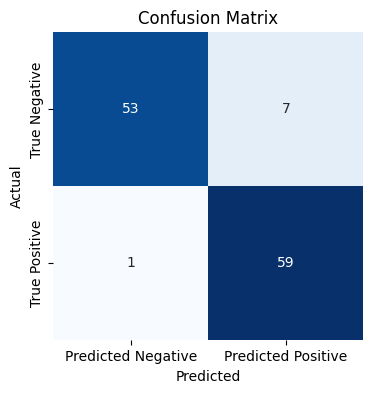

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666668
Sensitivity:  0.9833333333333333
Specificity:  0.9


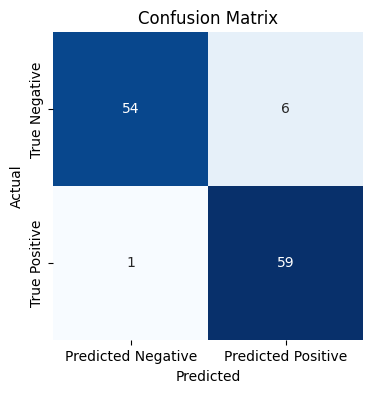

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 2

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Last epoch \\
Epoch 10/10 \\
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9784 - auc-roc: 0.9975 - loss: 0.0577

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9945663986089981
ROC-AUC:  0.9945663986089982
Sensitivity:  0.9923929580525973
Specificity:  0.9967398391653989


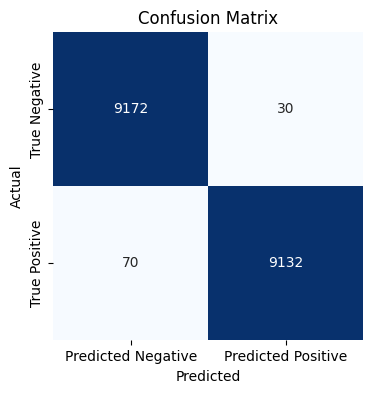

(0.9945663986089981,
 0.9945663986089982,
 0.9923929580525973,
 0.9967398391653989)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  1.0
Specificity:  0.8833333333333333


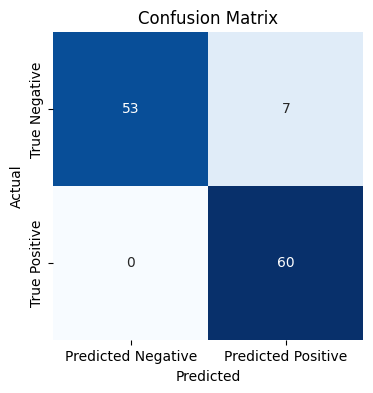

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9083333333333333
ROC-AUC:  0.9083333333333333
Sensitivity:  0.9666666666666667
Specificity:  0.85


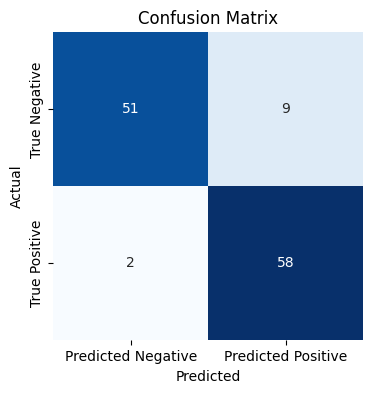

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.925
ROC-AUC:  0.9249999999999999
Sensitivity:  1.0
Specificity:  0.85


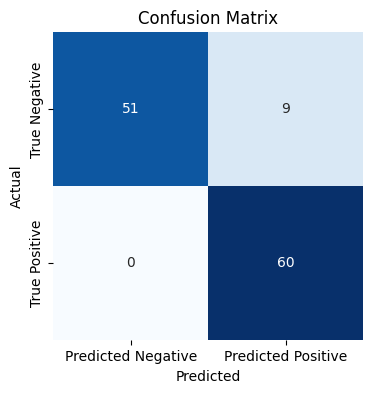

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.925
ROC-AUC:  0.925
Sensitivity:  0.9666666666666667
Specificity:  0.8833333333333333


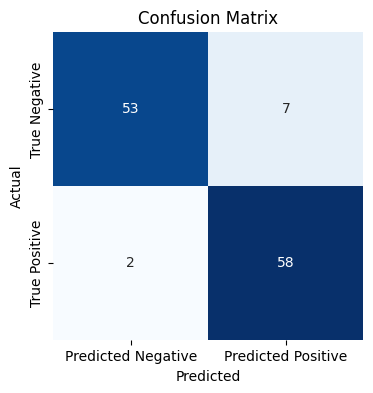

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 3

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Last epoch \\
Epoch 10/10 \\
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9800 - auc-roc: 0.9967 - loss: 0.0606

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9942403825255379
ROC-AUC:  0.9942403825255379
Sensitivity:  0.9929363181916975
Specificity:  0.9955444468593784


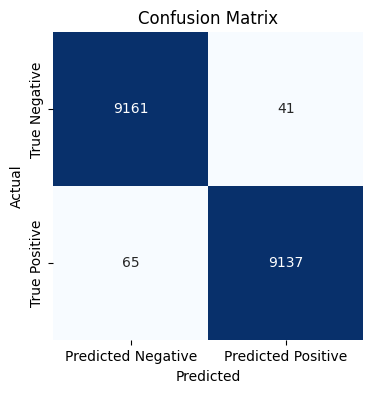

(0.9942403825255379,
 0.9942403825255379,
 0.9929363181916975,
 0.9955444468593784)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.925
ROC-AUC:  0.925
Sensitivity:  0.9833333333333333
Specificity:  0.8666666666666667


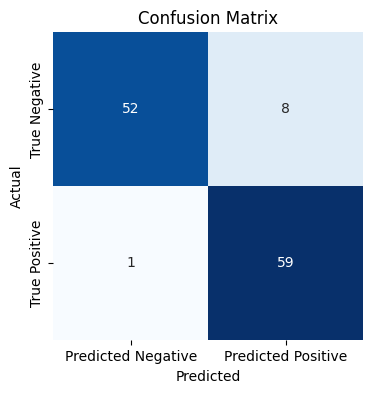

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.8916666666666667
ROC-AUC:  0.8916666666666667
Sensitivity:  0.9666666666666667
Specificity:  0.8166666666666667


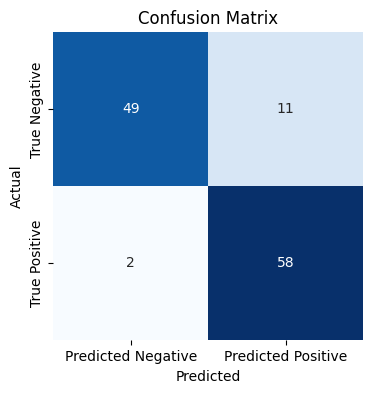

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.925
ROC-AUC:  0.9249999999999999
Sensitivity:  1.0
Specificity:  0.85


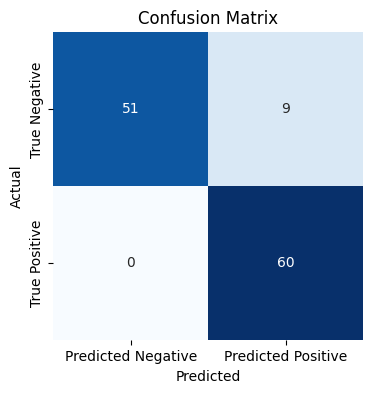

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  0.9666666666666667
Specificity:  0.9166666666666666


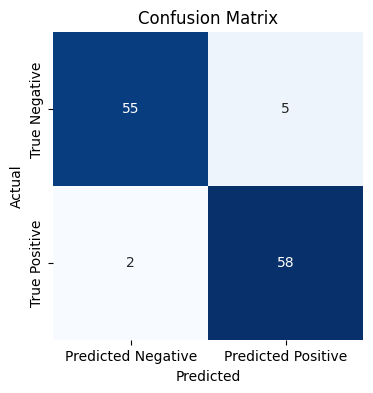

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 4

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Last epoch \\
Epoch 10/10 \\
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9775 - auc-roc: 0.9976 - loss: 0.0598

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Accuracy:  0.994457726581178
ROC-AUC:  0.994457726581178
Sensitivity:  0.9919582699413171
Specificity:  0.9969571832210389


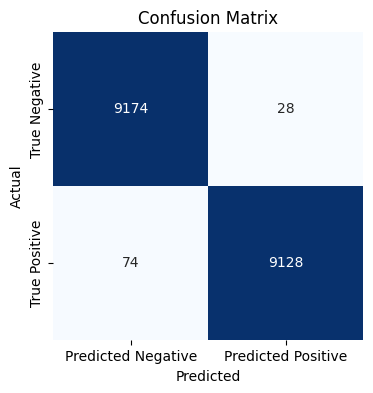

(0.994457726581178, 0.994457726581178, 0.9919582699413171, 0.9969571832210389)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.9333333333333333
ROC-AUC:  0.9333333333333335
Sensitivity:  0.9666666666666667
Specificity:  0.9


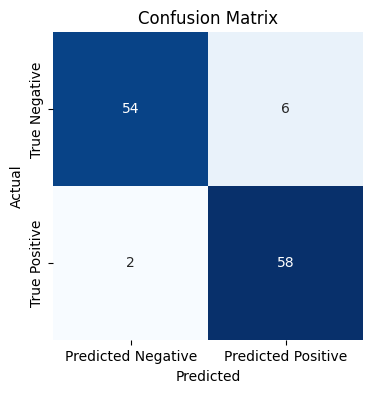

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666666
Sensitivity:  0.95
Specificity:  0.8833333333333333


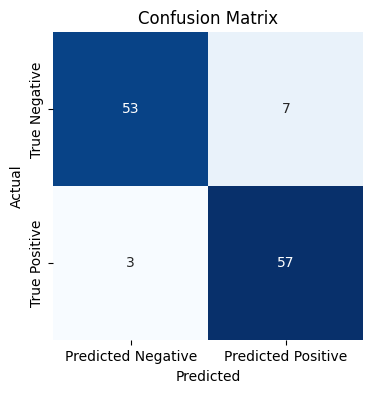

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666665
Sensitivity:  0.9166666666666666
Specificity:  0.9166666666666666


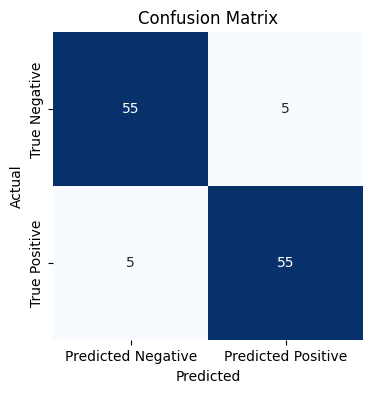

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9333333333333333
ROC-AUC:  0.9333333333333332
Sensitivity:  0.95
Specificity:  0.9166666666666666


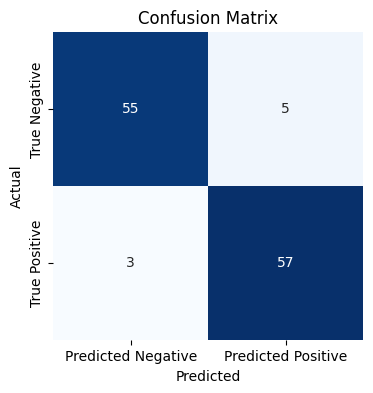

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 5

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  moxifloxacin # of train samples:  76
for drug  moxifloxacin # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Last epoch \\
Epoch 10/10 \\
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9759 - auc-roc: 0.9970 - loss: 0.0636

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9951640947620083
ROC-AUC:  0.9951640947620083
Sensitivity:  0.9947837426646381
Specificity:  0.9955444468593784


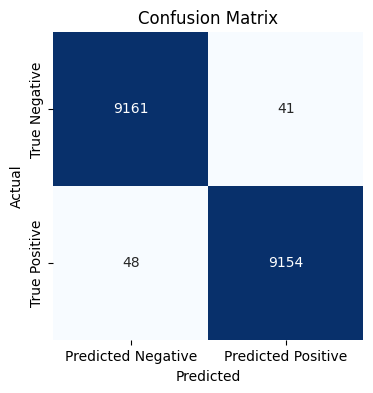

(0.9951640947620083,
 0.9951640947620083,
 0.9947837426646381,
 0.9955444468593784)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.9666666666666667
ROC-AUC:  0.9666666666666666
Sensitivity:  0.9833333333333333
Specificity:  0.95


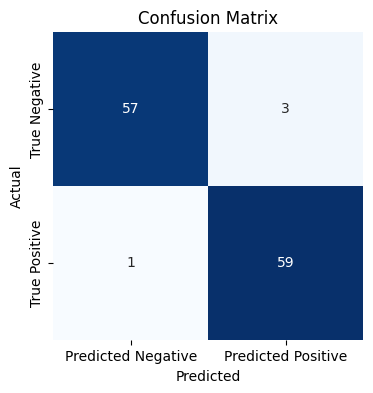

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  0.9666666666666667
Specificity:  0.9166666666666666


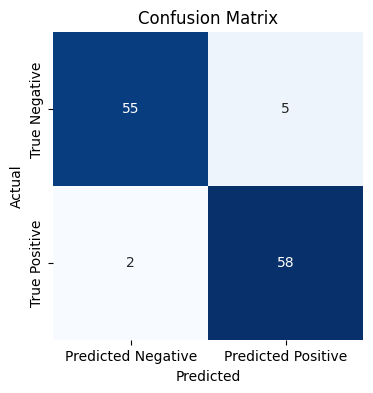

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9916666666666667
ROC-AUC:  0.9916666666666666
Sensitivity:  1.0
Specificity:  0.9833333333333333


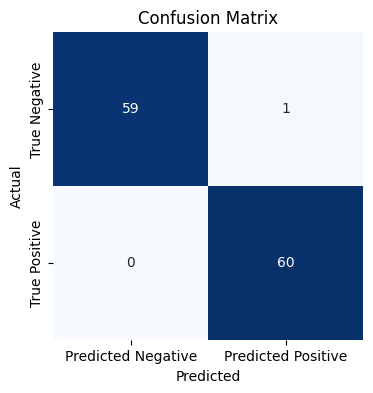

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9666666666666667
ROC-AUC:  0.9666666666666666
Sensitivity:  0.9833333333333333
Specificity:  0.95


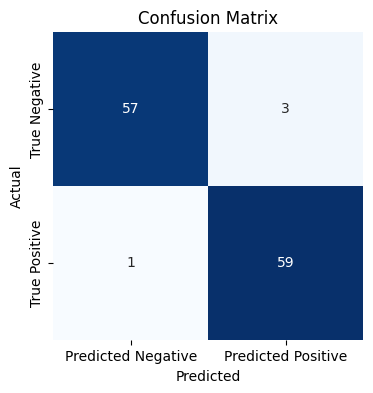

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 6

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for 

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5099 - auc-roc: 0.5089 - loss: 0.7673
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5053 - auc-roc: 0.5048 - loss: 0.7077
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5085 - auc-roc: 0.5111 - loss: 0.7000
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5008 - auc-roc: 0.4972 - loss: 0.6997
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5691 - auc-roc: 0.6099 - loss: 0.6573
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7479 - auc-roc: 0.8433 - loss: 0.4843
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7744 - auc-roc: 0.8693 - loss: 0.4456
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7899 - auc-roc: 0.8783 - loss: 0.4386
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8167 - auc-roc: 0.9020 - loss: 0.3980
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9931536622473376
ROC-AUC:  0.9931536622473375
Sensitivity:  0.9933710063029776
Specificity:  0.9929363181916975


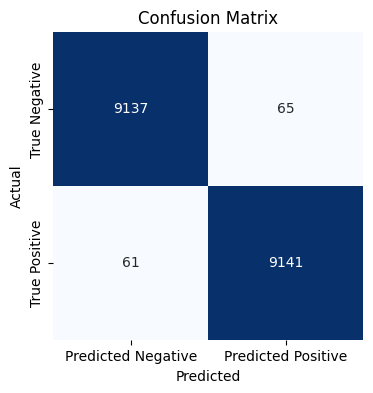

(0.9931536622473376,
 0.9931536622473375,
 0.9933710063029776,
 0.9929363181916975)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.925
ROC-AUC:  0.925
Sensitivity:  0.9666666666666667
Specificity:  0.8833333333333333


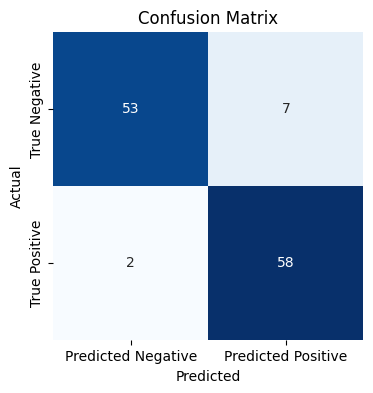

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9
ROC-AUC:  0.9
Sensitivity:  0.9333333333333333
Specificity:  0.8666666666666667


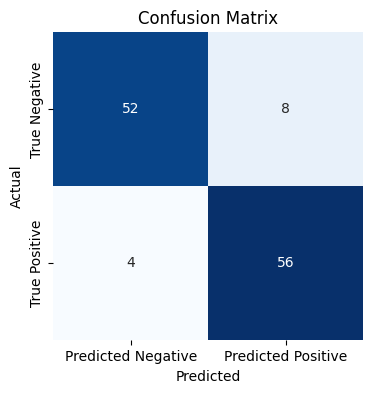

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  0.95
Specificity:  0.9333333333333333


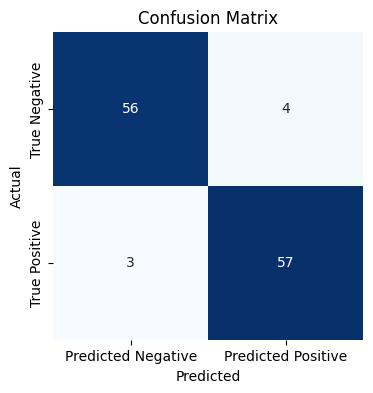

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9333333333333333
ROC-AUC:  0.9333333333333335
Sensitivity:  0.9666666666666667
Specificity:  0.9


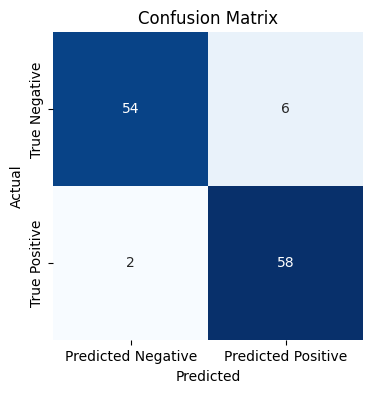

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 7

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for 

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5058 - auc-roc: 0.5063 - loss: 0.7685
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4939 - auc-roc: 0.4957 - loss: 0.7082
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4969 - auc-roc: 0.4960 - loss: 0.7010
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5001 - auc-roc: 0.4993 - loss: 0.6976
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7029 - auc-roc: 0.7925 - loss: 0.5417
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7389 - auc-roc: 0.8390 - loss: 0.4851
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7643 - auc-roc: 0.8652 - loss: 0.4524
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7840 - auc-roc: 0.8775 - loss: 0.4398
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8071 - auc-roc: 0.8943 - loss: 0.4109
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Accuracy:  0.9731036731145403
ROC-AUC:  0.9731036731145404
Sensitivity:  0.9803303629645729
Specificity:  0.9658769832645077


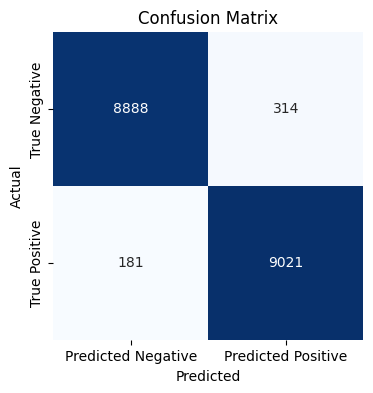

(0.9731036731145403,
 0.9731036731145404,
 0.9803303629645729,
 0.9658769832645077)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.95
ROC-AUC:  0.9500000000000001
Sensitivity:  1.0
Specificity:  0.9


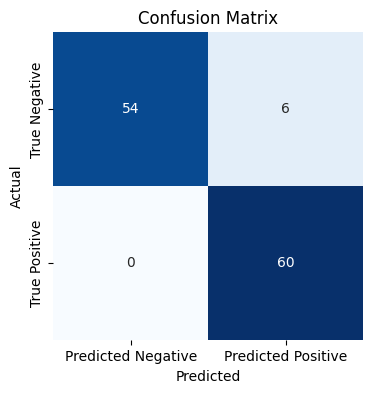

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666666
Sensitivity:  0.95
Specificity:  0.8833333333333333


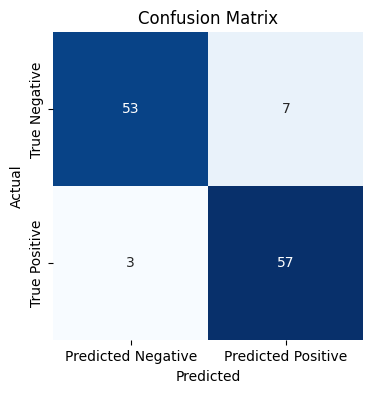

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9583333333333334
ROC-AUC:  0.9583333333333333
Sensitivity:  1.0
Specificity:  0.9166666666666666


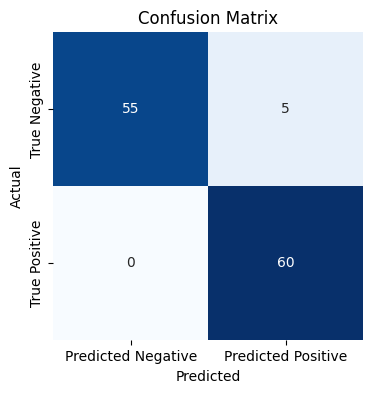

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9666666666666667
ROC-AUC:  0.9666666666666667
Sensitivity:  1.0
Specificity:  0.9333333333333333


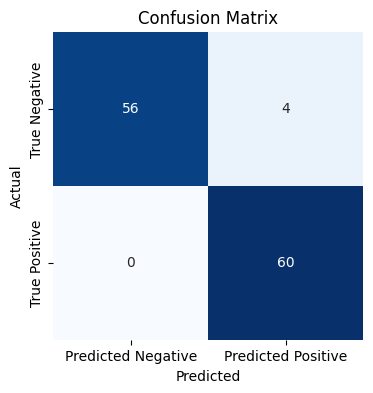

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 8

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for 

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5078 - auc-roc: 0.5106 - loss: 0.7852
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5074 - auc-roc: 0.5089 - loss: 0.7070
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4905 - auc-roc: 0.4922 - loss: 0.7031
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4991 - auc-roc: 0.4991 - loss: 0.6989
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5071 - auc-roc: 0.5066 - loss: 0.6963
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4971 - auc-roc: 0.5000 - loss: 0.6963
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6970 - auc-roc: 0.7837 - loss: 0.5540
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7525 - auc-roc: 0.8479 - loss: 0.4814
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7708 - auc-roc: 0.8646 - loss: 0.4577
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9828841556183439
ROC-AUC:  0.9828841556183437
Sensitivity:  0.9768528580743316
Specificity:  0.988915453162356


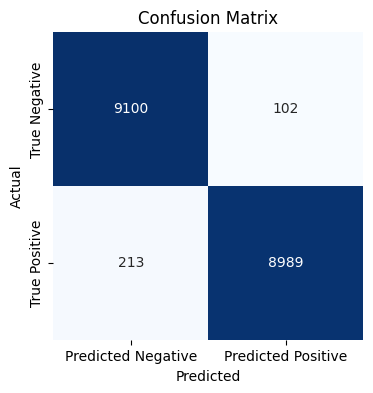

(0.9828841556183439, 0.9828841556183437, 0.9768528580743316, 0.988915453162356)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.95
ROC-AUC:  0.95
Sensitivity:  0.9833333333333333
Specificity:  0.9166666666666666


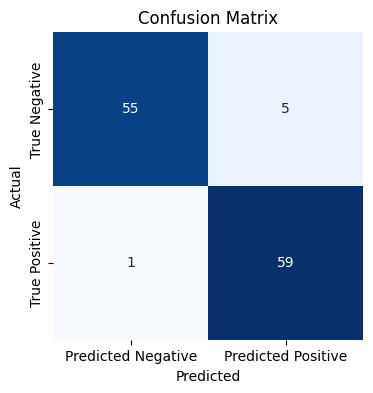

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666666
Sensitivity:  0.95
Specificity:  0.8833333333333333


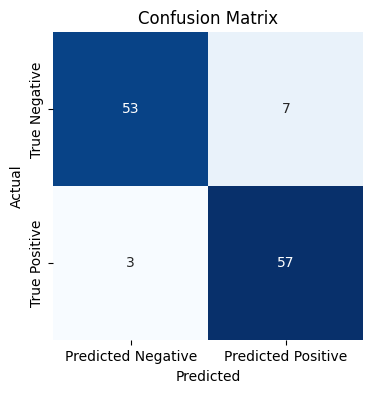

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.925
ROC-AUC:  0.9249999999999999
Sensitivity:  0.95
Specificity:  0.9


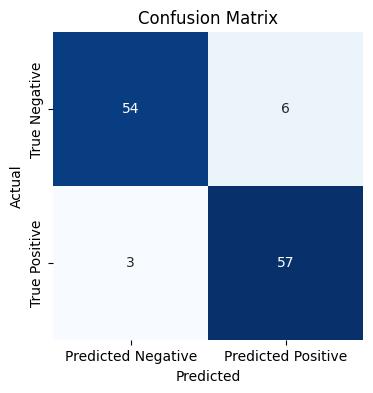

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666667
Sensitivity:  0.9666666666666667
Specificity:  0.8666666666666667


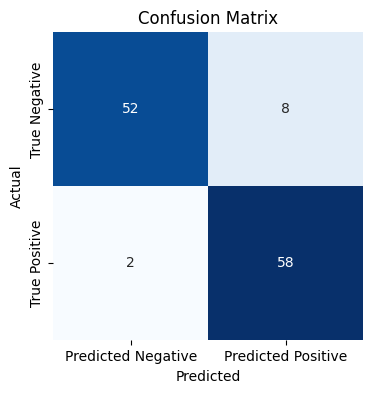

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 9

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for 

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.5034 - auc-roc: 0.5011 - loss: 0.8031
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4876 - auc-roc: 0.4870 - loss: 0.7173
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4974 - auc-roc: 0.4975 - loss: 0.7054
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5265 - auc-roc: 0.5471 - loss: 0.6842
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7310 - auc-roc: 0.8232 - loss: 0.5100
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7754 - auc-roc: 0.8676 - loss: 0.4548
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7879 - auc-roc: 0.8825 - loss: 0.4301
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8244 - auc-roc: 0.9078 - loss: 0.3879
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8422 - auc-roc: 0.9234 - loss: 0.3547
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9940230384698978
ROC-AUC:  0.9940230384698978
Sensitivity:  0.9968485111932188
Specificity:  0.9911975657465768


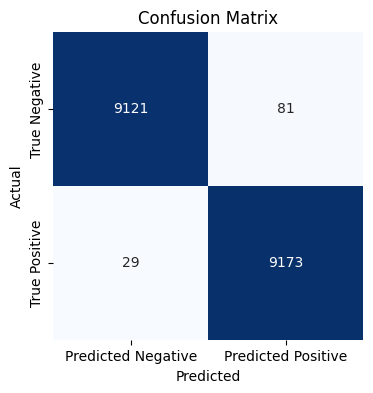

(0.9940230384698978,
 0.9940230384698978,
 0.9968485111932188,
 0.9911975657465768)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.9333333333333333
ROC-AUC:  0.9333333333333335
Sensitivity:  0.9666666666666667
Specificity:  0.9


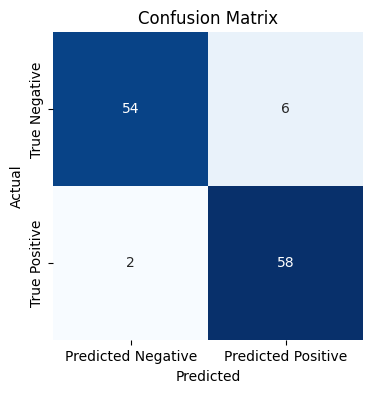

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.8916666666666667
ROC-AUC:  0.8916666666666666
Sensitivity:  0.9
Specificity:  0.8833333333333333


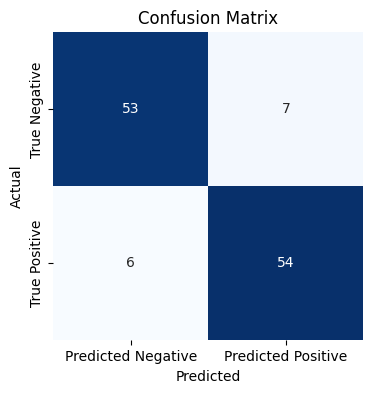

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  0.95
Specificity:  0.9333333333333333


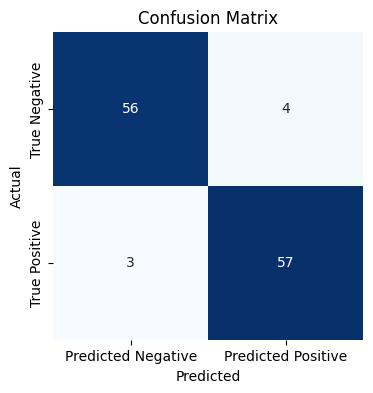

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9416666666666667
ROC-AUC:  0.9416666666666667
Sensitivity:  0.95
Specificity:  0.9333333333333333


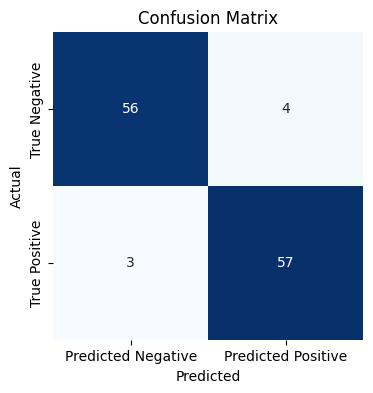

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Round 10

In [ ]:
# Splitting data
train_set, test_set, train_labels, test_labels = balanced_train_test_split(data, labels, drugs, 5)

for drug  meropenem # of train samples:  328
for drug  meropenem # of test samples:  10
for drug  amikacin # of train samples:  684
for drug  amikacin # of test samples:  10
for drug  ceftriaxone # of train samples:  657
for drug  ceftriaxone # of test samples:  10
for drug  imipenem # of train samples:  694
for drug  imipenem # of test samples:  10
for drug  tetracycline # of train samples:  683
for drug  tetracycline # of test samples:  10
for drug  cefotaxime # of train samples:  589
for drug  cefotaxime # of test samples:  10
for drug  doripenem # of train samples:  189
for drug  doripenem # of test samples:  10
for drug  gentamicin # of train samples:  656
for drug  gentamicin # of test samples:  10
for drug  levofloxacin # of train samples:  595
for drug  levofloxacin # of test samples:  10
for drug  ceftazidime # of train samples:  621
for drug  ceftazidime # of test samples:  10
for drug  ciprofloxacin # of train samples:  738
for drug  ciprofloxacin # of test samples:  10
for 

In [ ]:
triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

In [ ]:
train_labels = np.asarray(train_labels)
pairedLabels = np.asarray(pairedLabels)

### Training

#### Random Forest (RF)

In [ ]:
model = RandomForestClassifier(n_estimators=100).fit(train_set, train_labels[:, 1])
predict_RF = model.predict(test_set)

#### SVM

In [ ]:
model = SVC(kernel='poly').fit(train_set, train_labels[:, 1])
predict_SVM = model.predict(test_set)

#### XGBoost

In [ ]:
model = xgboost.XGBClassifier().fit(train_set, train_labels[:, 1])
predict_XGB = model.predict(test_set)

#### Triplet NN

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
triplet = np.asarray(triplet)

In [ ]:
triplet.shape

(18404, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)

In [ ]:
pairedLabels.shape

(18404, 2)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(25-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(train_set, train_labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.5012 - auc-roc: 0.4998 - loss: 0.8030
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4981 - auc-roc: 0.5012 - loss: 0.7131
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4932 - auc-roc: 0.4950 - loss: 0.7062
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5002 - auc-roc: 0.5018 - loss: 0.7005
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5248 - auc-roc: 0.5351 - loss: 0.6872
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7360 - auc-roc: 0.8314 - loss: 0.5000
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7593 - auc-roc: 0.8538 - loss: 0.4718
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7808 - auc-roc: 0.8753 - loss: 0.4385
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8031 - auc-roc: 0.8883 - loss: 0.4228
Epoch 10/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s

In [ ]:
train_pred = siamese_net.predict([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]])

576/576 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Accuracy:  0.9928276461638774
ROC-AUC:  0.9928276461638774
Sensitivity:  0.9956531188871984
Specificity:  0.9900021734405564


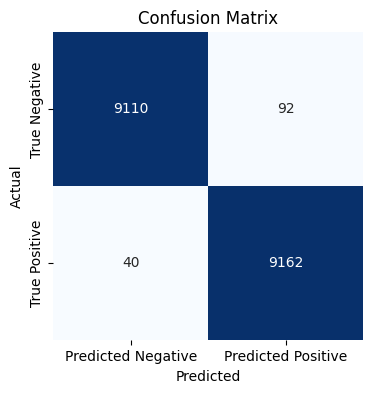

(0.9928276461638774,
 0.9928276461638774,
 0.9956531188871984,
 0.9900021734405564)

In [ ]:
# Similarity test for train_set
evaluation(pairedLabels[:, 0], train_pred)

## Validation

#### RF

In [ ]:
test_labels = np.asarray(test_labels)

Accuracy:  0.9166666666666666
ROC-AUC:  0.9166666666666667
Sensitivity:  0.9666666666666667
Specificity:  0.8666666666666667


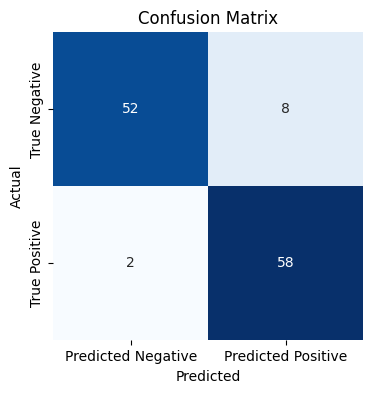

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_RF)

In [ ]:
rf_acc.append(acc)
rf_auc.append(auc)
rf_sen.append(sen)
rf_spc.append(spc)

#### SVM

Accuracy:  0.85
ROC-AUC:  0.8499999999999999
Sensitivity:  0.9166666666666666
Specificity:  0.7833333333333333


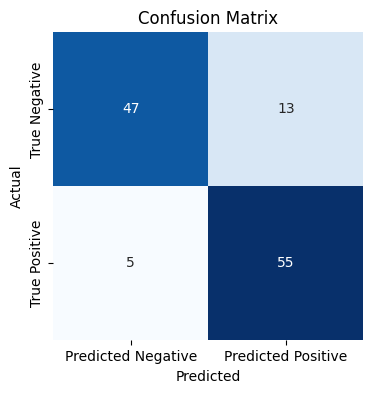

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_SVM)

In [ ]:
svm_acc.append(acc)
svm_auc.append(auc)
svm_sen.append(sen)
svm_spc.append(spc)

#### XGBoost

Accuracy:  0.9333333333333333
ROC-AUC:  0.9333333333333332
Sensitivity:  0.95
Specificity:  0.9166666666666666


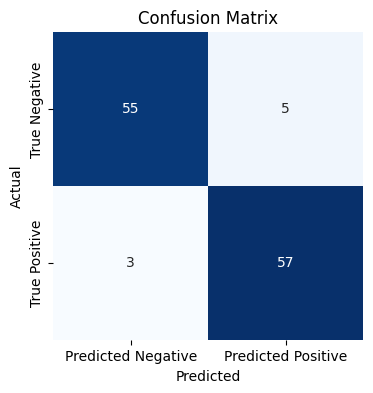

In [ ]:
acc, auc, sen, spc = evaluation(test_labels[:, 1], predict_XGB)

In [ ]:
xgb_acc.append(acc)
xgb_auc.append(auc)
xgb_sen.append(sen)
xgb_spc.append(spc)

#### Triplet NN

In [ ]:
test_labels = np.asarray(test_labels)
train_labels = np.asarray(train_labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test = RS_splitter(test_set, test_labels[:, 1])

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

60
2996
60
2996


In [ ]:
x0_train, x1_train = RS_splitter(train_set, train_labels[:, 1])

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1880
2996
4630
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

##### Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions


for i in x0_test:                     #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])


for i in x1_test:
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])

##### Phenotype prediction test

Accuracy:  0.9083333333333333
ROC-AUC:  0.9083333333333333
Sensitivity:  0.9666666666666667
Specificity:  0.85


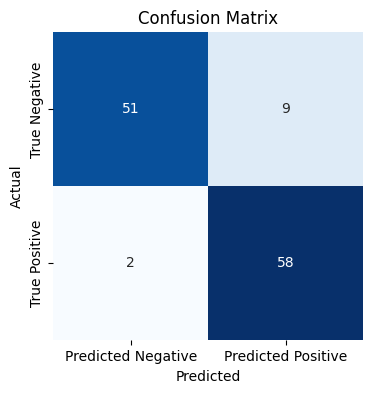

In [ ]:
acc, auc, sen, spc = evaluation(test_labels, aggre_preds)

In [ ]:
nn_acc.append(acc)
nn_auc.append(auc)
nn_sen.append(sen)
nn_spc.append(spc)

# Results

## RF

In [ ]:
print("Average accuracy: ", sum(rf_acc)/len(rf_acc))
print("Average AUC: ", sum(rf_auc)/len(rf_auc))
print("Average sensitivity: ", sum(rf_sen)/len(rf_sen))
print("Average specificity: ", sum(rf_spc)/len(rf_spc))

Average accuracy:  0.9333333333333333
Average AUC:  0.9333333333333332
Average sensitivity:  0.975
Average specificity:  0.8916666666666668


## SVM

In [ ]:
print("Average accuracy: ", sum(svm_acc)/len(svm_acc))
print("Average AUC: ", sum(svm_auc)/len(svm_auc))
print("Average sensitivity: ", sum(svm_sen)/len(svm_sen))
print("Average specificity: ", sum(svm_spc)/len(svm_spc))

Average accuracy:  0.905
Average AUC:  0.905
Average sensitivity:  0.945
Average specificity:  0.8649999999999999


## XGB

In [ ]:
print("Average accuracy: ", sum(xgb_acc)/len(xgb_acc))
print("Average AUC: ", sum(xgb_auc)/len(xgb_auc))
print("Average sensitivity: ", sum(xgb_sen)/len(xgb_sen))
print("Average specificity: ", sum(xgb_spc)/len(xgb_spc))

Average accuracy:  0.9391666666666666
Average AUC:  0.9391666666666666
Average sensitivity:  0.97
Average specificity:  0.9083333333333334


## NN

In [ ]:
print("Average accuracy: ", sum(nn_acc)/len(nn_acc))
print("Average AUC: ", sum(nn_auc)/len(nn_auc))
print("Average sensitivity: ", sum(nn_sen)/len(nn_sen))
print("Average specificity: ", sum(nn_spc)/len(nn_spc))

Average accuracy:  0.9375000000000002
Average AUC:  0.9375
Average sensitivity:  0.97
Average specificity:  0.905


In [ ]:
avg_acc = [sum(rf_acc)/len(rf_acc), sum(svm_acc)/len(svm_acc), sum(xgb_acc)/len(xgb_acc), sum(nn_acc)/len(nn_acc)]
print(avg_acc)

[0.9333333333333333, 0.905, 0.9391666666666666, 0.9375000000000002]


In [ ]:
avg_auc = [sum(rf_auc)/len(rf_auc), sum(svm_auc)/len(svm_auc), sum(xgb_auc)/len(xgb_auc), sum(nn_auc)/len(nn_auc)]
print(avg_auc)

[0.9333333333333332, 0.905, 0.9391666666666666, 0.9375]


In [ ]:
avg_sen = [sum(rf_sen)/len(rf_sen), sum(svm_sen)/len(svm_sen), sum(xgb_sen)/len(xgb_sen), sum(nn_sen)/len(nn_sen)]
print(avg_sen)

[0.975, 0.945, 0.97, 0.97]


In [ ]:
avg_spc = [sum(rf_spc)/len(rf_spc), sum(svm_spc)/len(svm_spc), sum(xgb_spc)/len(xgb_spc), sum(nn_spc)/len(nn_spc)]
print(avg_spc)

[0.8916666666666668, 0.8649999999999999, 0.9083333333333334, 0.905]


In [ ]:
avg_acc = [0.9333333333333333, 0.905, 0.9391666666666666, 0.9375000000000002]
avg_auc = [0.9333333333333332, 0.905, 0.9391666666666666, 0.9375]
avg_sen = [0.975, 0.945, 0.97, 0.97]
avg_spc = [0.8916666666666668, 0.8649999999999999, 0.9083333333333334, 0.905]

In [ ]:
import pandas as pd

data = [avg_acc, avg_auc, avg_sen, avg_spc]

results = pd.DataFrame(data, columns=['RF', 'SVM', 'XGB', 'NN'], index=['ACC', 'AUC', 'SEN', 'SPC'])

results

,RF,SVM,XGB,NN
ACC,0.933333,0.905,0.939167,0.9375
AUC,0.933333,0.905,0.939167,0.9375
SEN,0.975000,0.945,0.970000,0.9700
SPC,0.891667,0.865,0.908333,0.9050
